In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

import warnings
warnings.filterwarnings("ignore")

import apra_pop_models
from apra_pop_models.math_module import xp, _scipy, ensure_np_array
import apra_pop_models.fresnel_2dm_34 as fresnel
import apra_pop_models.fraunhofer_2dm_34 as fraunhofer
import apra_pop_models.utils as utils
import apra_pop_models.props as props
from apra_pop_models.imshows import imshow1, imshow2, imshow3
import apra_pop_models.efc_utils as efc_utils
import apra_pop_models.efc_2dm_embedded as efc

# import lina

/home/apra/miniconda3/envs/gpu311env/lib/python3.11/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


/home/apra/Projects/apra-howfsc-models/apra_pop_models


In [2]:
import sys
sys.path.insert(len(sys.path), '/home/apra/Projects/P5040/P5040_test_software/EFC/python_host')
import efc_host_utils

/home/apra/Projects/apra-howfsc-models/apra_pop_models


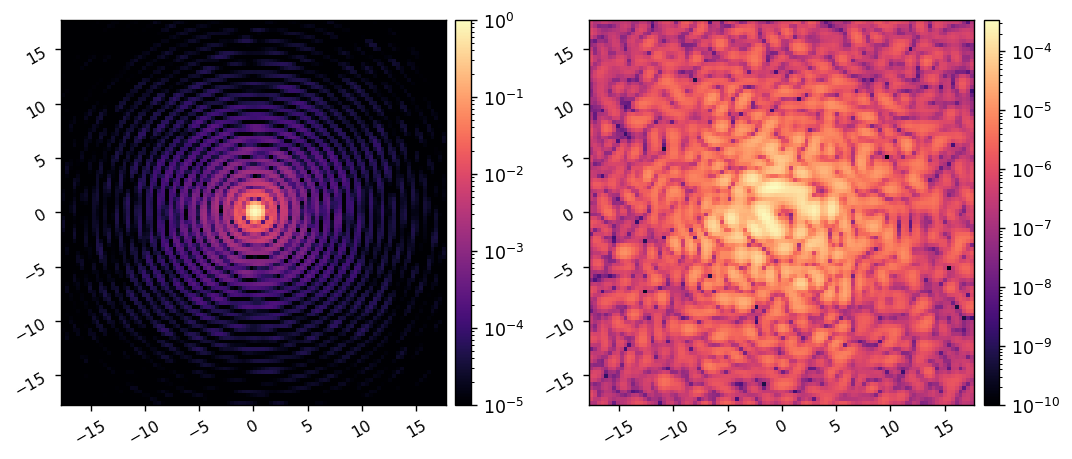

In [3]:
reload(fresnel)
I = fresnel.CORO()
I.use_opds = True

I.use_vortex = False
ref_psf = I.snap()
I.Imax_ref = xp.max(ref_psf)
ref_psf /= I.Imax_ref
I.use_vortex = True
ref_coro_im = I.snap()

imshow2(ref_psf, ref_coro_im,
        pxscl=I.psf_pixelscale_lamD, lognorm=True, vmin1=1e-5, vmin2=1e-10)

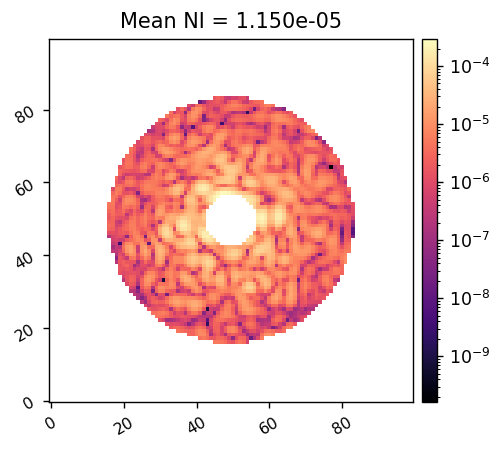

In [4]:
reload(efc_utils)
I.zero_dms()
iwa = 2.5
owa = 12
rot = 0
control_mask = efc_utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamD, irad=iwa, orad=owa, edge=None, rotation=rot)
mean_ni = xp.mean(ref_coro_im[control_mask])

imshow1(ref_coro_im*control_mask, f'Mean NI = {mean_ni:.3e}', lognorm=True)

In [5]:
reload(utils)
jac = utils.load_fits('../jacobians/jac.fits')

In [6]:
EC = efc_host_utils.EmbeddedController()

ConnectionRefusedError: [Errno 111] Connection refused

In [17]:
EC.send_jacobian(ensure_np_array(jac))

In [18]:
EC.do_ATA()

# Run EFC without PWP

In [14]:
I.zero_dms()
all_ims = []
all_efs = []
all_commands = []


In [23]:
EC.do_decomposition(-2.5)
# EC.do_decomposition(-5)

In [25]:
EC.close()

Close was called


Beginning closed-loop EFC simulation.
	Running iteration 4/6.
	Mean NI of this iteration: 4.670e-07


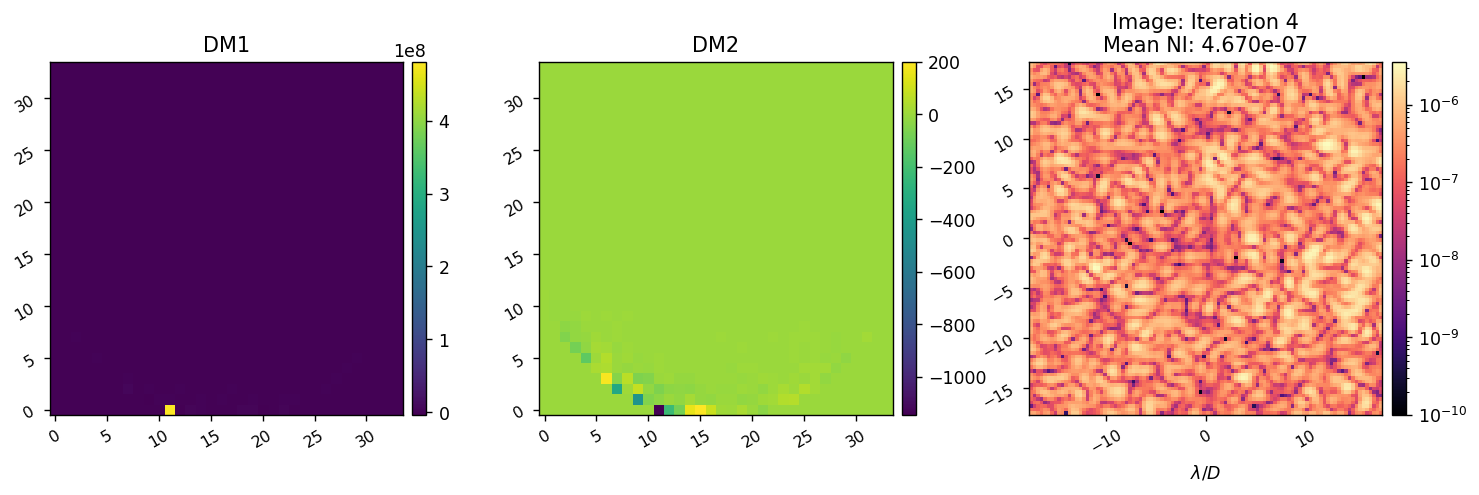

	Running iteration 5/6.
	Mean NI of this iteration: 3.933e-07


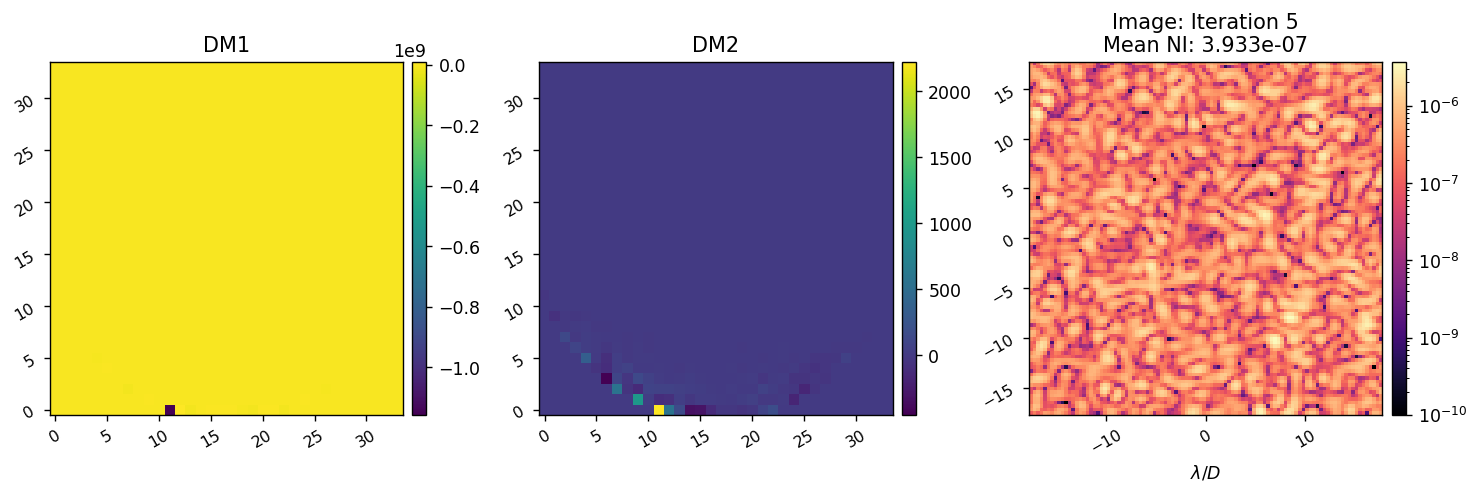

	Running iteration 6/6.
	Mean NI of this iteration: 3.184e-07


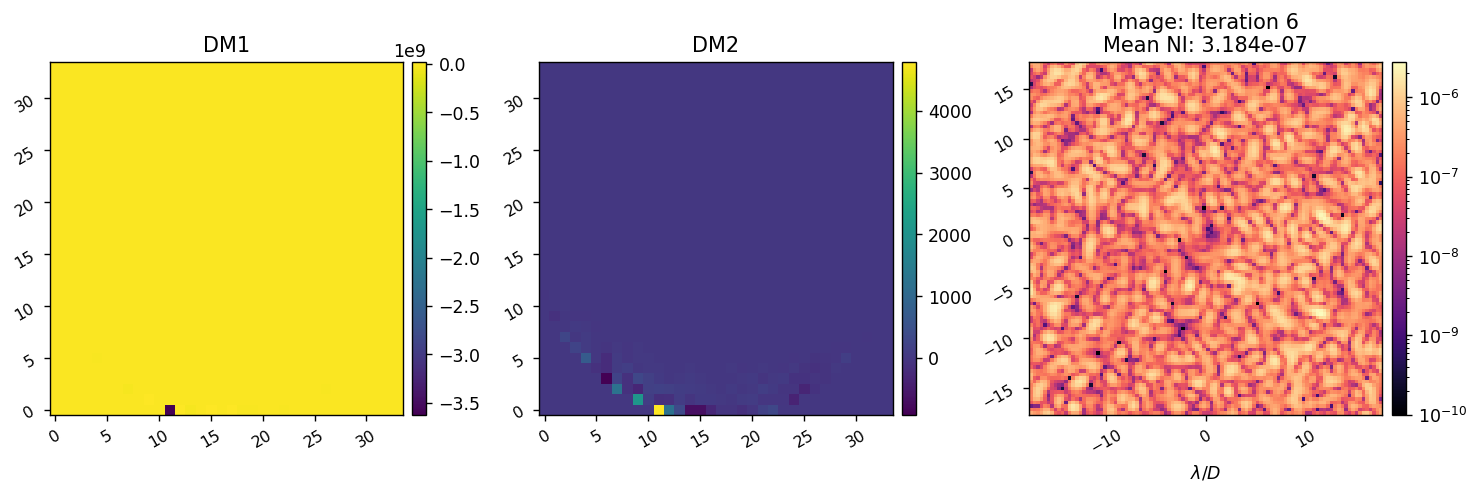

In [24]:
reload(efc)

all_ims, all_efs, all_commands = efc.run(I, EC,
                                        control_mask, 
                                        # est_fun=pwp_fun, est_params=pwp_params,
                                        gain=0.5, 
                                        iterations=3, 
                                        plot_all=True, 
                                        all_ims=all_ims,
                                        all_efs=all_efs,
                                        all_commands=all_commands,
                                        )